In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from keras import layers

import matplotlib.pyplot as plt
import zipfile
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import os
from PIL import Image

In [17]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [83]:
import os
# Määritä ZIP-tiedoston nimi ja kohdekansio
zip_tiedoston_nimi = 'syopa.zip'  # Korvaa 'nimesi.zip' ZIP-tiedostosi nimellä
kohdekansio = '.'  # Tämä tarkoittaa nykyistä kansiota Jupyterissa

with zipfile.ZipFile(zip_tiedoston_nimi, 'r') as zip_ref:
    zip_ref.extractall(kohdekansio)

print(f"'{zip_tiedoston_nimi}' on purettu onnistuneesti.")

#tarkista tiedostorakenne: Kuten aiemmin, voit tarkistaa, onko tiedostorakenne kuten odotit: python
# Tarkista, onko tiedostorakenne oikein
for dataset in ['train', 'test', 'val']:
    for category in ['benign', 'malignant']:
        polku = os.path.join(kohdekansio, 'output', dataset, category)
        if os.path.exists(polku):
            print(f"Alikansio {dataset}/{category} on olemassa.")
        else:
            print(f"Alikansiota {dataset}/{category} ei löydy!")


'syopa.zip' on purettu onnistuneesti.
Alikansio train/benign on olemassa.
Alikansio train/malignant on olemassa.
Alikansio test/benign on olemassa.
Alikansio test/malignant on olemassa.
Alikansio val/benign on olemassa.
Alikansio val/malignant on olemassa.


In [84]:

# Here we load the images and do some preprocessing for them. We do the following preprocessing steps:
# - transform the into arrays
# - resize them to a smaller resolution
# - convert the image to B&W
# - Normalize the arrays

def transform_image(kuva):

    kuva = Image.open(kuva).convert('L')
    new_size = (28, 28)

    resized_image = kuva.resize(new_size, Image.BILINEAR)

    kuva_array = tf.keras.preprocessing.image.img_to_array(resized_image)
    normalized_array = (kuva_array - kuva_array.min()) / (kuva_array.max() - kuva_array.min())

    return normalized_array


# Iterating through the folders to apply preprocessing for all images in the dataset 

def go_through_folder(folder):
    array_list =[]
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        array = transform_image(file_path)
        array_list.append(array)
        
    return array_list
        
#test_image = transform_image("output/train/benign/SOB_B_A-14-22549AB-400-001.png")   
benign_train = np.array(go_through_folder("output/train/benign"))
malignant_train = np.array(go_through_folder("output/train/malignant"))
benign_test = np.array(go_through_folder("output/test/benign"))
malignant_test = np.array(go_through_folder("output/test/malignant"))
benign_val = np.array(go_through_folder("output/val/benign"))
malignant_val = np.array(go_through_folder("output/val/malignant"))


/tmp/ipykernel_595/1042247800.py:12: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  resized_image = kuva.resize(new_size, Image.BILINEAR)


In [86]:
# Creating the Y labels for their respective images, 1 being a malignant tumor, 0 being a benign tumor
# Also preparing them to their respective train and test sets
benign_train_label = np.zeros(len(benign_train))
benign_test_label = np.zeros(len(benign_test))

malignant_train_label = np.ones(len(malignant_train))
malignant_test_label = np.ones(len(malignant_test))

malignant_val_label = np.ones(len(malignant_val))
benign_val_label = np.zeros(len(benign_val))




X_train = np.concatenate((benign_train, malignant_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malignant_train_label), axis = 0)


X_test = np.concatenate((benign_test, malignant_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malignant_test_label), axis = 0)

X_val = np.concatenate((benign_val, malignant_val), axis = 0)
Y_val = np.concatenate((benign_val_label, malignant_val_label), axis = 0)


min_samples = min(len(benign_train), len(malignant_train))

# Otetaan alijäämä suuremmasta luokasta
if len(benign_train) > len(malignant_train):
    indices = np.random.choice(len(benign_train), min_samples, replace=False)  # Valitaan satunnaisesti indeksejä
    benign_train = benign_train[indices]
    benign_train_label = benign_train_label[indices]
else:
    indices = np.random.choice(len(malignant_train), min_samples, replace=False)  # Valitaan satunnaisesti indeksejä
    malignant_train = malignant_train[indices]
    malignant_train_label = malignant_train_label[indices]

# Yhdistetään datat kuten ennenkin
X_train = np.concatenate((benign_train, malignant_train), axis=0)
Y_train = np.concatenate((benign_train_label, malignant_train_label), axis=0)

# Sekoitetaan koulutusdata
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]



s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

s = np.arange(X_val.shape[0])
np.random.shuffle(s)
X_val = X_val[s]
Y_val = Y_val[s]



In [63]:
X_train.shape


(764, 150, 150, 1)

In [72]:
model = models.Sequential()

model.add(layers.Conv2D(2, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(2, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(2, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(2, activation='relu'))
model.add(layers.Dense(2))
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 26, 26, 2)         20        
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 13, 13, 2)        0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 11, 11, 2)         38        
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 5, 5, 2)          0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 3, 3, 2)           38        
                                                                 
 flatten_12 (Flatten)        (None, 18)              

In [78]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 22.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [89]:
from tensorflow import keras
import optuna

def objective(trial):
    num_layers = trial.suggest_int('num_layers', 1, 3)
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(28, 28, 1)))

    for i in range(num_layers):
        units = trial.suggest_categorical(f'conv_{i}_units', [2, 4, 8])
        model.add(keras.layers.Conv2D(units, (3, 3), activation='relu'))
        model.add(keras.layers.MaxPooling2D((2, 2)))

    model.add(keras.layers.Flatten())
    dense_units = trial.suggest_categorical('dense_units', [2, 4, 8])
    model.add(keras.layers.Dense(dense_units, activation='relu'))
    model.add(keras.layers.Dense(2))

    model.compile(optimizer='adam',
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    history = model.fit(X_train, Y_train,
                        epochs=5,
                        validation_data=(X_val, Y_val),
                        batch_size=32,
                        verbose=0)

    return history.history['val_accuracy'][-1]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Tulosta parhaat hyperparametrit
best_params = study.best_params

[I 2023-09-21 12:59:23,305] A new study created in memory with name: no-name-253286c9-713e-45bf-8ef9-edd39299ba83
[I 2023-09-21 12:59:24,562] Trial 0 finished with value: 0.3241106867790222 and parameters: {'num_layers': 1, 'conv_0_units': 8, 'dense_units': 4}. Best is trial 0 with value: 0.3241106867790222.
[I 2023-09-21 12:59:25,841] Trial 1 finished with value: 0.5533596873283386 and parameters: {'num_layers': 1, 'conv_0_units': 8, 'dense_units': 8}. Best is trial 1 with value: 0.5533596873283386.
[I 2023-09-21 12:59:27,380] Trial 2 finished with value: 0.6126482486724854 and parameters: {'num_layers': 3, 'conv_0_units': 2, 'conv_1_units': 4, 'conv_2_units': 2, 'dense_units': 8}. Best is trial 2 with value: 0.6126482486724854.
[I 2023-09-21 12:59:28,871] Trial 3 finished with value: 0.4071146249771118 and parameters: {'num_layers': 3, 'conv_0_units': 8, 'conv_1_units': 4, 'conv_2_units': 8, 'dense_units': 2}. Best is trial 2 with value: 0.6126482486724854.
[I 2023-09-21 12:59:30,386

In [90]:
model = keras.Sequential()
model.add(keras.layers.Input(shape=(28, 28, 1)))

# Lisää konvoluutiot ja max-pooling kerrokset määrätyn määrän perusteella
for i in range(best_params['num_layers']):
    conv_units = best_params[f'conv_{i}_units']
    model.add(keras.layers.Conv2D(conv_units, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(best_params['dense_units'], activation='relu'))
model.add(keras.layers.Dense(2))

model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Kouluta malli (tässä voit käyttää enemmän epookkeja kuin hyperparametrioptimoinnissa)
history = model.fit(X_train, Y_train,
                    epochs=20,
                    validation_data=(X_val, Y_val))

Epoch 1/20
24/24 [==============================] - 1s 14ms/step - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6903 - val_accuracy: 0.6759
Epoch 2/20
24/24 [==============================] - 0s 11ms/step - loss: 0.6930 - accuracy: 0.5000 - val_loss: 0.6892 - val_accuracy: 0.6601
Epoch 3/20
24/24 [==============================] - 0s 10ms/step - loss: 0.6927 - accuracy: 0.5236 - val_loss: 0.6923 - val_accuracy: 0.4941
Epoch 4/20
24/24 [==============================] - 0s 11ms/step - loss: 0.6924 - accuracy: 0.5079 - val_loss: 0.6908 - val_accuracy: 0.5059
Epoch 5/20
24/24 [==============================] - 0s 10ms/step - loss: 0.6929 - accuracy: 0.4921 - val_loss: 0.6926 - val_accuracy: 0.4545
Epoch 6/20
24/24 [==============================] - 0s 11ms/step - loss: 0.6917 - accuracy: 0.5223 - val_loss: 0.6883 - val_accuracy: 0.5455
Epoch 7/20
24/24 [==============================] - 0s 10ms/step - loss: 0.6913 - accuracy: 0.5236 - val_loss: 0.6912 - val_accuracy: 0.5178
Epoch 8/20
24

In [73]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs = 7, shuffle = True,
                    validation_data=(X_val, Y_val))

Epoch 1/7
24/24 [==============================] - 1s 14ms/step - loss: 0.6952 - accuracy: 0.4908 - val_loss: 0.6943 - val_accuracy: 0.5771
Epoch 2/7
24/24 [==============================] - 0s 9ms/step - loss: 0.6940 - accuracy: 0.4843 - val_loss: 0.6946 - val_accuracy: 0.4901
Epoch 3/7
24/24 [==============================] - 0s 10ms/step - loss: 0.6936 - accuracy: 0.4712 - val_loss: 0.6934 - val_accuracy: 0.6087
Epoch 4/7
24/24 [==============================] - 0s 9ms/step - loss: 0.6934 - accuracy: 0.5013 - val_loss: 0.6942 - val_accuracy: 0.4743
Epoch 5/7
24/24 [==============================] - 0s 10ms/step - loss: 0.6932 - accuracy: 0.5144 - val_loss: 0.6940 - val_accuracy: 0.4506
Epoch 6/7
24/24 [==============================] - 0s 9ms/step - loss: 0.6931 - accuracy: 0.5039 - val_loss: 0.6930 - val_accuracy: 0.4822
Epoch 7/7
24/24 [==============================] - 0s 10ms/step - loss: 0.6929 - accuracy: 0.4974 - val_loss: 0.6929 - val_accuracy: 0.4901


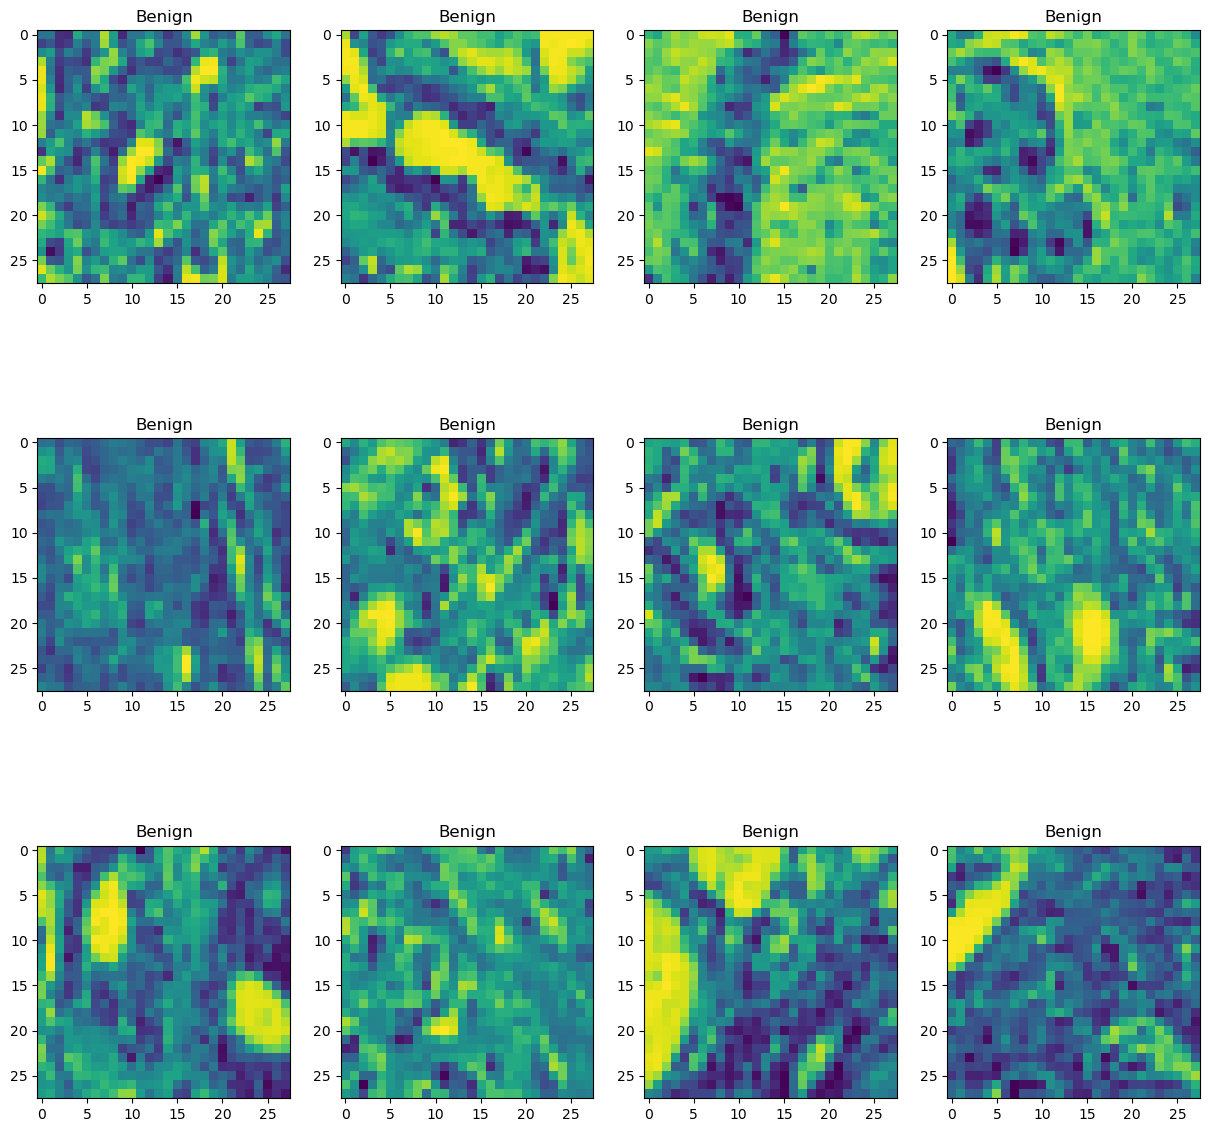

In [54]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

w=28
h=28
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

8/8 - 0s - loss: 0.6149 - accuracy: 0.6758 - 97ms/epoch - 12ms/step


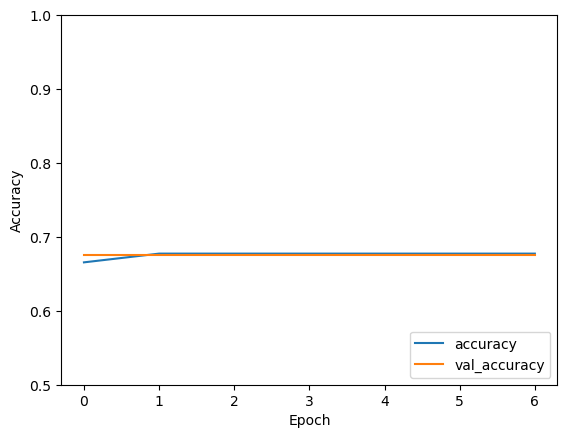

In [48]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)